# Computer Vision


| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

#  Importing Pytorch

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.9.1+cpu


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#  Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


yes, the dataset is downloaded and it have 3 type of image `pizza` `sushi` `steak` having train and test class
train class have 75 images and test class have an 25 images

In [4]:
# setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

lets vizulize an image

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


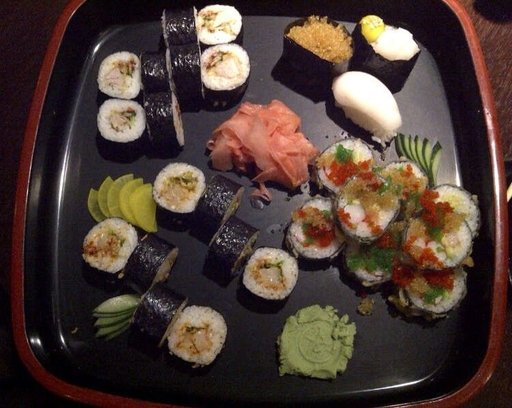

In [5]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# Transforming the Data

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

Turn it into tensors (numerical representations of our images).

Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader for short.

There are several data set problem since we are looking for an image we will use `TorchVision`

In [6]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms

##  Transforming data with `torchvision.transforms`


To get experience with torchvision.transforms, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.
4. We can compile all of these steps using `torchvision.transforms.Compose()`.

In [7]:
data_transform = transforms.Compose([
    # resize the image to 100 * 100
    transforms.Resize(size=(100,100)),
    # turn image to tensor
    transforms.ToTensor(),
    # flip the image randomly
    transforms.RandomHorizontalFlip(p=0.5),  # 50 % chance of probablities
])

In [8]:
data_transform(img)

tensor([[[0.1255, 0.1373, 0.1333,  ..., 0.0784, 0.0824, 0.0824],
         [0.1294, 0.1333, 0.1412,  ..., 0.0824, 0.0824, 0.0863],
         [0.1255, 0.1255, 0.1412,  ..., 0.0902, 0.0863, 0.0902],
         ...,
         [0.0235, 0.0275, 0.0275,  ..., 0.1373, 0.1373, 0.1294],
         [0.0275, 0.0314, 0.0314,  ..., 0.1412, 0.1333, 0.1255],
         [0.0314, 0.0314, 0.0314,  ..., 0.1255, 0.1255, 0.1255]],

        [[0.0510, 0.0588, 0.0588,  ..., 0.0392, 0.0471, 0.0431],
         [0.0667, 0.0588, 0.0549,  ..., 0.0431, 0.0392, 0.0392],
         [0.0588, 0.0510, 0.0510,  ..., 0.0431, 0.0353, 0.0314],
         ...,
         [0.0118, 0.0078, 0.0078,  ..., 0.0706, 0.0706, 0.0627],
         [0.0118, 0.0118, 0.0157,  ..., 0.0745, 0.0745, 0.0706],
         [0.0118, 0.0118, 0.0157,  ..., 0.0627, 0.0667, 0.0706]],

        [[0.0588, 0.0667, 0.0667,  ..., 0.0627, 0.0745, 0.0706],
         [0.0745, 0.0706, 0.0706,  ..., 0.0784, 0.0745, 0.0745],
         [0.0824, 0.0745, 0.0824,  ..., 0.0980, 0.0863, 0.

In [9]:
data_transform(img).shape

torch.Size([3, 100, 100])

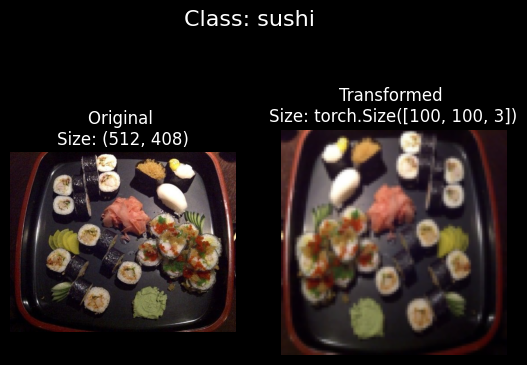

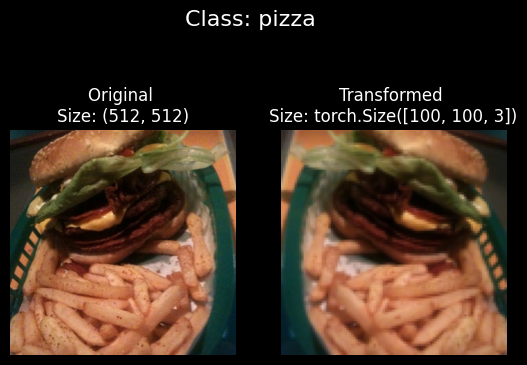

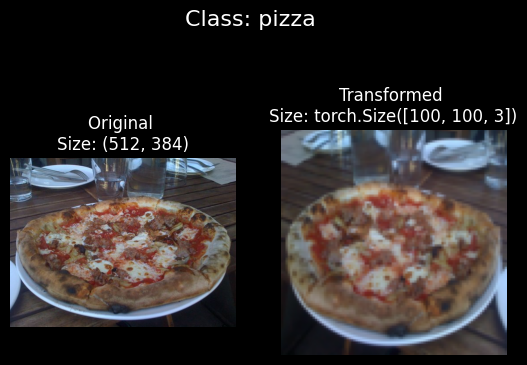

In [10]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Loading Image Data using `ImageFolder`

trhence we  have created an transformer for the image for
1. To convert into Tensor
2. to flip horizotally
3. to resize image

now convert that image to an format that PyTorch can use

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder for conversion
                                  transform=data_transform, # transforms to perform on images
                                  target_transform=None) # transforms to perform on Labels

test_data = datasets.ImageFolder(root=test_dir,  # target folder for conversion
                                 transform=data_transform)  # transforms to perform on images

print(f"train_data:{train_data}")
print("=" * 100 )
print(f"test_data:{test_data}")

train_data:Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
test_data:Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )


lets check our data set through some operations

In [12]:
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data),len(test_data)

(225, 75)

total 225 data for training and 75 for testing

In [15]:
img , label = train_data[0][0] , train_data[0][1]
print(f"image : {img}")
print(f"label : {label}")
print(f"image datatype : {img.dtype}")

print(f"image shape: {img.shape}")

image : tensor([[[0.1137, 0.1098, 0.1059,  ..., 0.1137, 0.1137, 0.1137],
         [0.1098, 0.1059, 0.0980,  ..., 0.1294, 0.1255, 0.1294],
         [0.1059, 0.0980, 0.0941,  ..., 0.1333, 0.1294, 0.1333],
         ...,
         [0.0863, 0.0902, 0.0980,  ..., 0.1647, 0.1647, 0.1725],
         [0.0863, 0.0863, 0.0902,  ..., 0.1686, 0.1647, 0.1765],
         [0.0902, 0.0863, 0.0863,  ..., 0.1608, 0.1608, 0.1647]],

        [[0.0706, 0.0706, 0.0706,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0745, 0.0745,  ..., 0.0627, 0.0627, 0.0667],
         [0.0706, 0.0745, 0.0706,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.1098, 0.1176, 0.1176,  ..., 0.2431, 0.2314, 0.2353],
         [0.1059, 0.1059, 0.1059,  ..., 0.2353, 0.2275, 0.2314],
         [0.1059, 0.1020, 0.1020,  ..., 0.2392, 0.2275, 0.2275]],

        [[0.0941, 0.0941, 0.0902,  ..., 0.0196, 0.0196, 0.0235],
         [0.0941, 0.0902, 0.0902,  ..., 0.0235, 0.0196, 0.0235],
         [0.0902, 0.0902, 0.0863,  ..., 0.0157, 0.

How about we plot a single image tensor using matplotlib?

We'll first have  to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

original image permuted : torch.Size([3, 100, 100])
permuted image permuted : torch.Size([100, 100, 3])


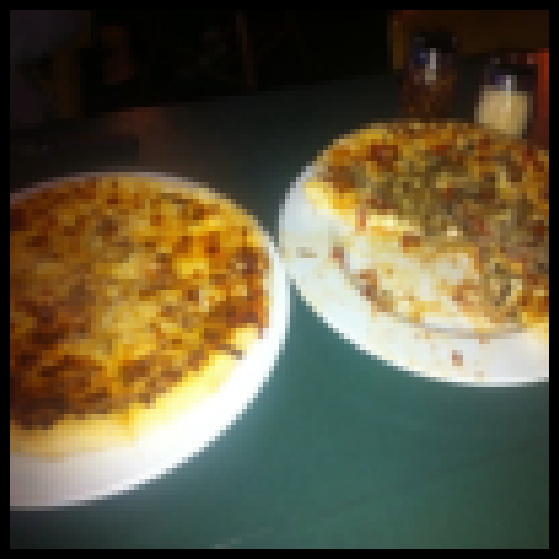

In [17]:
# permute the image ( change in Dimension )
img_permute = img.permute(1, 2, 0)

# print out diffrent shapes ( before and afterv permute )
print(f"original image permuted : {img.shape}")
print(f"permuted image permuted : {img_permute.shape}")
# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.show()

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,
                          batch_size=1, # how many samples per batch?
                          num_workers=1, # # how many subprocesses to use for data loading? (higher = more)
                          shuffle=True)

test_dataloader = DataLoader(test_data,
                         batch_size=1,
                         num_workers=1,
                         shuffle=True)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fee0daa630>,
 <torch.utils.data.dataloader.DataLoader at 0x1fe96d96330>)

# Other forms of transforms (data augmentation)


**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

The idea behind TrivialAugment is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

In [20]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),

])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out

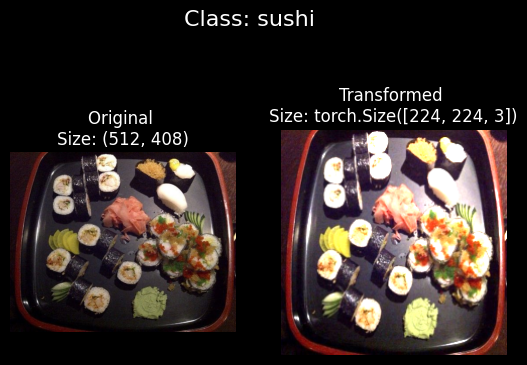

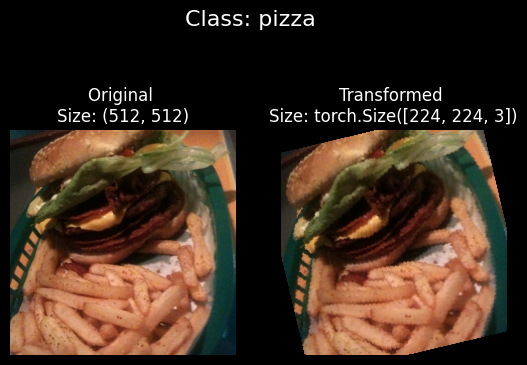

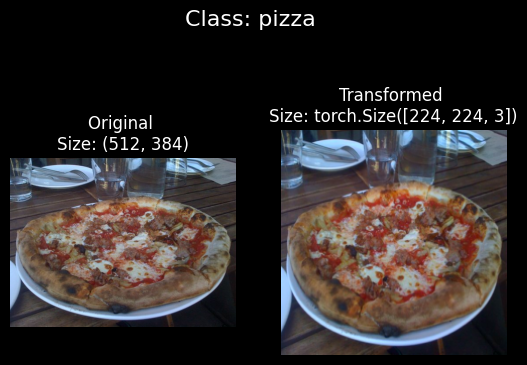

In [24]:
# get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# plot the random images
plot_transformed_images(
    image_path_list,
    transform=train_transforms,
    n=3,
    seed=42
)

# model 0 : TinyVGG Without data augmentation

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors